In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import statsmodels.api as sm

from preprocessor import prepare_data, get_features, get_upper_bounds, get_lower_bounds
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from lightgbm import LGBMRegressor

# Load in pre-split data
X_train, X_test, y_train, y_test = prepare_data()
features = get_features()

Train data(range):
2019-04-11 21:49:48
2019-06-14 19:06:40
Test data(range):
2019-06-14 19:07:10
2019-08-22 19:05:05


In [33]:
y_train_lower_bounds = get_lower_bounds(y_train, 5)
y_train_upper_bounds = get_upper_bounds(y_train, 5)
y_test_lower_bounds = get_lower_bounds(y_test, 5)
y_test_upper_bounds = get_upper_bounds(y_test, 5)

In [34]:
y_train = list(np.array(y_train).flatten())
y_test = list(np.array(y_test).flatten())

## Gradient Boosting Model(s)

#### GradientBoostingRegressor

In [18]:
lower_alpha = 0.1
upper_alpha = 0.9
lower_model = GradientBoostingRegressor(loss="quantile", alpha=lower_alpha, n_estimators=200, max_depth=2)
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=200, max_depth=2)
upper_model = GradientBoostingRegressor(loss="quantile", alpha=upper_alpha, n_estimators=200, max_depth=2)

In [19]:
lower_model.fit(X_train, y_train)
mid_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)
predictions = pd.DataFrame(y_test)
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

In [20]:
predictions

,0,lower,mid,upper
0,43.55,40.724993,41.240929,57.956430
1,60.30,41.374993,53.254432,60.248332
2,52.45,40.724993,56.316602,77.922834
3,41.20,41.374993,49.818499,60.300004
4,52.45,40.724993,56.656248,77.922834
...,...,...,...,...
12495,90.50,56.425357,78.886848,102.396529
12496,47.30,41.374993,41.951513,60.248332
12497,47.30,41.374993,39.761983,60.300004
12498,60.30,41.374993,41.264174,60.300004


In [132]:
model = GradientBoostingRegressor(n_estimators=500, max_depth=8, loss='ls', min_samples_split=2, learning_rate=0.01)

In [133]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8991995788870305

In [134]:
test_score = np.zeros((500,), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)

Text(0, 0.5, 'Deviance')

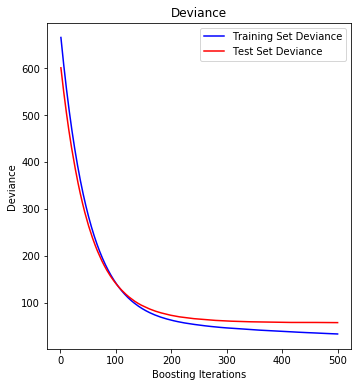

In [135]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(500) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(500) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [136]:
mean_squared_error(y_test, model.predict(X_test))

57.634284261143804

In [145]:
train_pred = model.predict(X_train)
train_preds_acc = []
for i in range(len(y_train)):
    if (y_train_lower_bounds.iloc[i].price <= train_pred[i] <= y_train_upper_bounds.iloc[i].price):
        train_preds_acc.append(1)
    else:
        train_preds_acc.append(0)
        
test_pred = model.predict(X_test)
test_preds_acc = []
for i in range(len(y_test)):
    if (y_test_lower_bounds.iloc[i].price <= test_pred[i] <= y_test_upper_bounds.iloc[i].price):
        test_preds_acc.append(1)
    else:
        test_preds_acc.append(0)

In [146]:
print(np.mean(train_preds_acc))
print(np.mean(test_preds_acc))

0.55424
0.46488


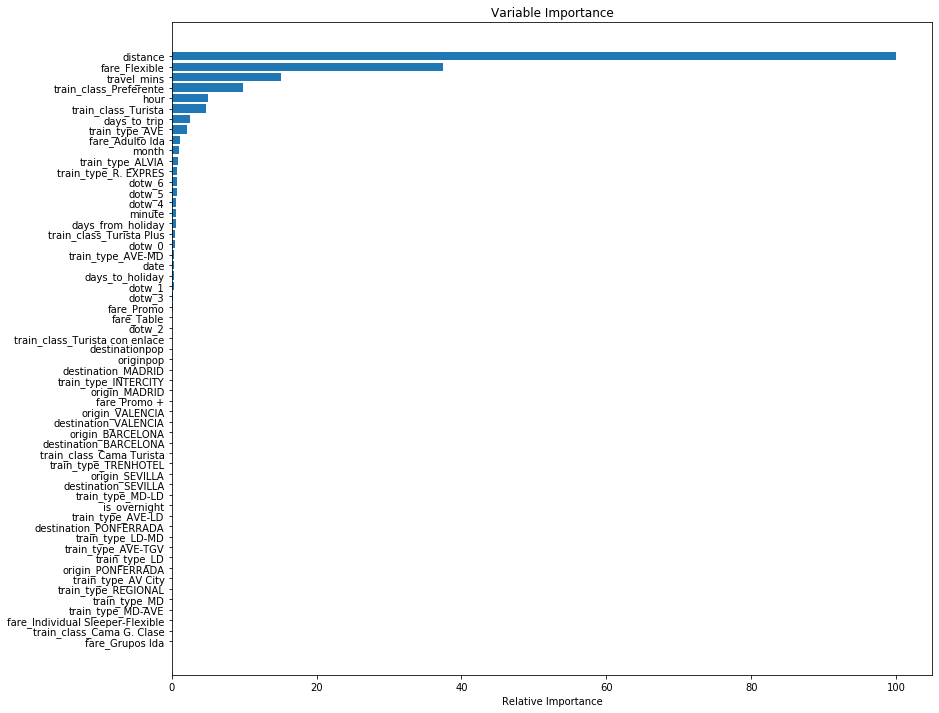

In [169]:
indices = np.array(list(range(len(features))))
features = np.array(features)[indices.astype(int)]
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(30, 12))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [194]:
drops_ind = [1, 2, 7, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, \
             30, 32, 33, 34, 35, 36, 37, 38, \
             39, 40, 42, 43, 46, 47, 48, 49, 50, 51, 52, 55, 56]
x_train_new_1 = np.delete(X_train, drops_ind, axis=1)
x_test_new_1 = np.delete(X_test, drops_ind, axis=1)
features_new_1 = []
for i in range(len(features)):
    if features[i] not in drops_ind:
        features_new_1.append(features[i])

In [195]:
model_1 = GradientBoostingRegressor(n_estimators=500, max_depth=8, loss='ls', min_samples_split=2, learning_rate=0.01)

In [196]:
model_1.fit(x_train_new_1, y_train)
model_1.score(x_test_new_1, y_test)

0.8964308835415096

In [197]:
mean_squared_error(y_test, model_1.predict(x_test_new_1))

59.217330966845836

In [181]:
features_df = pd.DataFrame(features, list(range(len(features))), columns = ['feat'])
features_df

,feat
0,travel_mins
1,originpop
2,destinationpop
3,days_to_holiday
4,days_from_holiday
5,distance
6,month
7,date
8,hour
9,minute


#### Light Gradient Boosting Regression

In [55]:
lgbm = LGBMRegressor(n_estimators=150, random_state=1)
lgbm.fit(X_train, y_train)
lgbm.score(X_test, y_test)

0.8965714902659896

In [35]:
train_pred = lgbm.predict(X_train)
train_preds_acc = []
for i in range(len(y_train)):
    if (y_train_lower_bounds.iloc[i].price <= train_pred[i] <= y_train_upper_bounds.iloc[i].price):
        train_preds_acc.append(1)
    else:
        train_preds_acc.append(0)
        
test_pred = lgbm.predict(X_test)
test_preds_acc = []
for i in range(len(y_test)):
    if (y_test_lower_bounds.iloc[i].price <= test_pred[i] <= y_test_upper_bounds.iloc[i].price):
        test_preds_acc.append(1)
    else:
        test_preds_acc.append(0)

In [41]:
print(np.mean(train_preds_acc))
print(np.mean(test_preds_acc))
print(mean_squared_error(y_test, test_pred))

0.546
0.43232
59.13693677961698


In [43]:
features_imp_df = pd.DataFrame(list(lgbm.feature_importances_), features, columns = ['importance'])
features_imp_df

,importance
travel_mins,613
originpop,118
destinationpop,37
days_to_holiday,224
days_from_holiday,183
distance,127
month,151
date,195
hour,716
minute,198


In [35]:
features_imp_df['importance'][4]

183

In [44]:
zeros_ind = []
zeros_feat = []
for i in range(len(features)):
    if features_imp_df['importance'][i] == 0:
        zeros_ind.append(i)
        zeros_feat.append(features_imp_df.iloc[i].name)


In [45]:
x_train_new = np.delete(X_train, zeros_ind, axis=1)
x_test_new = np.delete(X_test, zeros_ind, axis=1)
features_new = []
for i in range(len(features)):
    if features[i] not in zeros_feat:
        features_new.append(features[i])

In [46]:
lgbm_new = LGBMRegressor(n_estimators=150, random_state=1)
lgbm_new.fit(x_train_new, y_train)
lgbm_new.score(x_test_new, y_test)
test_pred_new = lgbm_new.predict(x_test_new)
mean_squared_error(y_test, test_pred_new)

59.13693677961698

In [50]:
features_imp_df_new = pd.DataFrame(list(lgbm_new.feature_importances_), features_new, columns = ['importance'])
features_imp_df_new

,importance
travel_mins,613
originpop,118
destinationpop,37
days_to_holiday,224
days_from_holiday,183
distance,127
month,151
date,195
hour,716
minute,198


In [53]:
lgbm_rfe = LGBMRegressor(n_estimators=150, random_state=1)
rfe = RFE(lgbm_rfe, 20)
x_rfe_train = rfe.fit_transform(x_train_new, y_train)
x_rfe_test = rfe.transform(x_test_new)
lgbm_rfe.fit(x_rfe_train, y_train)
lgbm_rfe.score(x_rfe_test, y_test)

0.8943629480484874

In [54]:
pred_rfe_test = lgbm_rfe.predict(x_rfe_test)
mean_squared_error(y_test, pred_rfe_test)

60.39970680141667